> **MHEALTH 데이터셋의 자이로스코프 데이터(레이블 있음)와 대용량의 MergeData.csv 데이터셋의 자이로스코프 데이터(레이블 없음)를 결합하여, 동일한 전처리를 거쳐 CNN-LSTM 모델을 학습하고, 이를 통해 MergeData.csv 데이터의 행동 레이블을 예측하여 추가**   
> **하이퍼파라미터 튜닝을 통해 모델의 성능을 높이고, 예측 결과를 시각적으로 검증 및 평가**

# 목차
1. 필요한 라이브러리 임포트 및 설정
2. 슬라이딩 윈도우 함수 정의
3. 특성 추출 함수 정의
4. 데이터 증강 함수 정의
5 .MHEALTH 데이터 로드 및 전처리
6. MergeData.csv 데이터 로드 및 전처리
7. 레이블이 있는 데이터와 없는 데이터 결합
8. 데이터셋 분할 및 시퀀스 생성
9. 데이터셋 및 데이터로더 생성
10. CNN-LSTM 모델 정의
11. 하이퍼파라미터 튜닝
12. 모델 학습
13. 모델 평가 및 시각화
14. MergeData.csv 데이터에 대한 예측 및 레이블 추가
15. 마무리

# 1. 필요한 라이브러리 임포트 및 설정

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # 진행 상황 표시

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pywt
import optuna  # 하이퍼파라미터 튜닝을 위한 라이브러리

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 디바이스: {device}")
if device.type == 'cuda':
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")

사용 중인 디바이스: cuda
GPU 이름: NVIDIA GeForce GTX 1650


- 필요한 라이브러리를 모두 임포트합니다.
- GPU가 사용 가능한 경우 GPU를 사용하도록 설정합니다.
- tqdm 라이브러리를 사용하여 진행 상황을 표시합니다.

# 2. 슬라이딩 윈도우 함수 정의

In [2]:
def sliding_window(data, window_size, step_size):
    """
    슬라이딩 윈도우를 적용하여 데이터를 윈도우로 분할합니다.

    Parameters:
        data (numpy array): 입력 데이터 (samples, channels).
        window_size (int): 윈도우 크기.
        step_size (int): 윈도우 이동 크기.

    Returns:
        numpy array: 윈도우로 분할된 데이터 (num_windows, window_size, channels).
    """
    
    num_samples = data.shape[0]
    
    if num_samples < window_size:
        return np.array([])  # 빈 배열 반환
        
    windows = []
    
    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window = data[start:end, :]
        windows.append(window)
        
    return np.array(windows)

# 3. 특성 추출 함수 정의

In [3]:
def extract_features(windows):
    """
    각 윈도우에 대해 특성을 추출합니다.

    Parameters:
        windows (numpy array): 윈도우로 분할된 데이터 (num_windows, window_size, channels).

    Returns:
        numpy array: 추출된 특성 (num_windows, num_features).
    """
    
    features = []
    
    for window in windows:
        window_features = []
        
        if window.ndim == 1:
            window = window[:, np.newaxis]
            
        num_channels = window.shape[1]
        
        for channel in range(num_channels):
            signal = window[:, channel]
            
            # 기본 통계량
            mean = np.mean(signal)
            std = np.std(signal)
            skewness = stats.skew(signal)
            kurtosis = stats.kurtosis(signal)
            rms = np.sqrt(np.mean(signal**2))
            
            # FFT
            fft_coeffs = np.fft.rfft(signal)
            fft_mean = np.mean(np.abs(fft_coeffs))
            fft_std = np.std(np.abs(fft_coeffs))
            
            # 웨이블릿 변환 후 에너지
            coeffs = pywt.wavedec(signal, 'db1', level=3)
            energy = sum([np.sum(c**2) for c in coeffs])
            
            # 특성 벡터에 추가
            window_features.extend([mean, std, skewness, kurtosis, rms, fft_mean, fft_std, energy])
            
        features.append(window_features)
        
    return np.array(features)

# 4. 데이터 증강 함수 정의

In [4]:
def augment_data(X, y):
    """
    데이터 증강을 위해 가우시안 노이즈를 추가합니다.

    Parameters:
        X (numpy array): 입력 데이터.
        y (numpy array): 레이블.

    Returns:
        tuple: 증강된 데이터와 레이블.
    """
    
    noise = np.random.normal(0, 0.01, X.shape)
    X_augmented = X + noise
    y_augmented = y.copy()
    
    return X_augmented, y_augmented

# 5. MHEALTH 데이터 로드 및 전처리
***
## 5.1 데이터 로드

In [5]:
# 데이터 파일 경로 설정 (실제 데이터 경로로 수정하세요)
data_files = glob.glob('C:/AI/data/MHEALTHDATASET/mHealth_subject*.log')

# 데이터와 레이블을 저장할 리스트 초기화
X_list = []
y_list = []

for file in data_files:
    data = pd.read_csv(file, sep='\s+', header=None)
    print(f"파일명: {file}")
    print(f"data.shape: {data.shape}")
    
    # 데이터의 열 수가 24개인지 확인
    if data.shape[1] != 24:
        print(f"데이터의 열 수가 24가 아닙니다. 파일을 확인하세요.")
        continue  # 다음 파일로 넘어감

    # 우측 하완 센서의 자이로스코프 데이터 추출 (열 18~20)
    right_arm_gyro = data.iloc[:, 17:20].values   # 열 18~20 (Python 인덱스는 0부터 시작)
    print(f"right_arm_gyro.shape: {right_arm_gyro.shape}")

    # 레이블 추출 (열 24)
    labels = data.iloc[:, 23].values
    print(f"labels.shape: {labels.shape}")

    # null 클래스(레이블 0)는 제외
    valid_indices = labels != 0
    sensor_data = right_arm_gyro[valid_indices, :]  # 모든 열 선택
    labels = labels[valid_indices]

    # 데이터와 레이블 저장
    X_list.append(sensor_data)
    y_list.append(labels)

파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject1.log
data.shape: (161280, 24)
right_arm_gyro.shape: (161280, 3)
labels.shape: (161280,)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject10.log
data.shape: (98304, 24)
right_arm_gyro.shape: (98304, 3)
labels.shape: (98304,)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject2.log
data.shape: (130561, 24)
right_arm_gyro.shape: (130561, 3)
labels.shape: (130561,)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject3.log
data.shape: (122112, 24)
right_arm_gyro.shape: (122112, 3)
labels.shape: (122112,)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject4.log
data.shape: (116736, 24)
right_arm_gyro.shape: (116736, 3)
labels.shape: (116736,)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject5.log
data.shape: (119808, 24)
right_arm_gyro.shape: (119808, 3)
labels.shape: (119808,)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject6.log
data.shape: (98304, 24)
right_arm_gyro.shape: (98304, 3)
labels.shape: (98304,)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject7.log
data.sha

- MHEALTH 데이터셋에서 자이로스코프 데이터와 레이블을 추출합니다.
- null 클래스(레이블 0)는 제외합니다.

## 5.2 데이터 결합

In [6]:
# 리스트를 배열로 변환
X_raw_mhealth = np.vstack(X_list)
y_raw_mhealth = np.hstack(y_list)

# 레이블을 0부터 시작하도록 조정
y_raw_mhealth = y_raw_mhealth - 1  # 레이블이 1부터 시작하므로 0부터 시작하도록 조정

print("전체 MHEALTH 데이터 크기:", X_raw_mhealth.shape)
print("전체 MHEALTH 레이블 크기:", y_raw_mhealth.shape)

전체 MHEALTH 데이터 크기: (343195, 3)
전체 MHEALTH 레이블 크기: (343195,)


## 5.3 슬라이딩 윈도우 적용 및 특성 추출

In [7]:
# 윈도우 설정
window_size = 128  # 샘플 수에 따라 조정 가능
step_size = 64

# 슬라이딩 윈도우 적용
windows = sliding_window(X_raw_mhealth, window_size, step_size)
labels = sliding_window(y_raw_mhealth.reshape(-1, 1), window_size, step_size)

# 각 윈도우의 레이블은 가장 많이 등장하는 레이블로 설정
window_labels = [np.bincount(label_window.flatten().astype(int)).argmax() for label_window in labels]

# 특성 추출
X_features_mhealth = extract_features(windows)
y_labels_mhealth = np.array(window_labels)

print("MHEALTH 데이터 특성 크기:", X_features_mhealth.shape)
print("MHEALTH 레이블 크기:", y_labels_mhealth.shape)

MHEALTH 데이터 특성 크기: (5361, 24)
MHEALTH 레이블 크기: (5361,)


# 6. MergeData.csv 데이터 로드 및 전처리
***
## 6.1 데이터 로드 및 슬라이딩 윈도우 적용

In [8]:
# MergeData.csv 파일 경로 설정 (실제 경로로 수정하세요)
merge_data_path = 'C:/AI/data/MergeData.csv'

# 청크 크기 설정 (메모리 용량에 따라 조정)
chunk_size = 100000  # 한 번에 읽어올 행의 수

# 데이터와 레이블을 저장할 리스트 초기화
X_list_merge = []

# 컬럼 이름 지정
column_names = ['VitalDate',
                'WorkDate',
                'UserCode',
                'HeartBeat',
                'Temperature',
                'OutsideTemperature',
                'Latitude',
                'Longitude',
                'X',
                'Y',
                'Z']

# 데이터 로드 및 전처리
reader = pd.read_csv(merge_data_path,
                     chunksize=chunk_size,
                     names=column_names,
                     header=0)

for chunk in tqdm(reader, desc='MergeData 로드 중'):
    # 자이로스코프 데이터 추출 (X, Y, Z 컬럼)
    gyro_data = chunk[['X', 'Y', 'Z']].values

    # 슬라이딩 윈도우 적용
    windows = sliding_window(gyro_data,
                             window_size=128,
                             step_size=64)
    
    if windows.size == 0:
        continue

    # 특성 추출
    features = extract_features(windows)

    # 데이터 저장
    X_list_merge.append(features)

MergeData 로드 중: 2760it [3:42:18,  4.83s/it]


- MergeData.csv를 청크 단위로 읽어옵니다.
- 자이로스코프 데이터(X, Y, Z 컬럼)를 추출합니다.
- 슬라이딩 윈도우와 특성 추출을 적용합니다.
- 레이블이 없으므로 레이블은 저장하지 않습니다.

## 6.2 데이터 결합

In [9]:
# 리스트를 배열로 변환
X_raw_merge = np.vstack(X_list_merge)

print("전체 MergeData 특성 데이터 크기:", X_raw_merge.shape)

전체 MergeData 특성 데이터 크기: (4308055, 24)


# 7. 레이블이 있는 데이터와 없는 데이터 결합
***
## 7.1 데이터 결합

In [10]:
# MHEALTH 데이터의 레이블은 그대로 유지
X_total = np.vstack((X_features_mhealth, X_raw_merge))
# 레이블은 MHEALTH 데이터의 레이블과 MergeData의 레이블(없는 부분)을 결합
y_total = np.hstack((y_labels_mhealth, np.full(X_raw_merge.shape[0], -1)))  # 레이블이 없는 부분은 -1로 표시

print("결합된 데이터 크기:", X_total.shape)
print("결합된 레이블 크기:", y_total.shape)

결합된 데이터 크기: (4313416, 24)
결합된 레이블 크기: (4313416,)


## 7.2 데이터 증강 및 스케일링

In [11]:
# MHEALTH 데이터에 대해서만 데이터 증강 적용
X_augmented, y_augmented = augment_data(X_features_mhealth, y_labels_mhealth)

# 원본 MHEALTH 데이터와 증강된 데이터 결합
X_mhealth_combined = np.vstack((X_features_mhealth, X_augmented))
y_mhealth_combined = np.hstack((y_labels_mhealth, y_augmented))

# 전체 데이터 결합 (MHEALTH 데이터와 MergeData 데이터)
X_total = np.vstack((X_mhealth_combined, X_raw_merge))
y_total = np.hstack((y_mhealth_combined, np.full(X_raw_merge.shape[0], -1)))  # 레이블이 없는 부분은 -1로 표시

print("결합된 데이터 크기:", X_total.shape)
print("결합된 레이블 크기:", y_total.shape)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_total)

# 스케일러 저장
joblib.dump(scaler, 'scaler_total.pkl')

결합된 데이터 크기: (4318777, 24)
결합된 레이블 크기: (4318777,)


['scaler_total.pkl']

- 레이블이 있는 MHEALTH 데이터에 대해서만 데이터 증강을 수행합니다.
- 전체 데이터를 스케일링합니다

# 8. 데이터셋 분할 및 시퀀스 생성
***
## 8.1 레이블이 있는 데이터와 없는 데이터 분리

In [12]:
# 레이블이 있는 데이터만 분리
X_labeled = X_scaled[y_total != -1]
y_labeled = y_total[y_total != -1].astype(int)

# 레이블이 없는 데이터만 분리
X_unlabeled = X_scaled[y_total == -1]

## 8.2 학습 및 검증 데이터 분할

In [13]:
# 레이블이 있는 데이터셋 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled,
    y_labeled,
    test_size=0.2,
    random_state=42,
    stratify=y_labeled
)

print("학습 데이터 크기:", X_train.shape)
print("검증 데이터 크기:", X_val.shape)

학습 데이터 크기: (8577, 24)
검증 데이터 크기: (2145, 24)


## 8.3 시퀀스 생성

In [14]:
# 시퀀스 길이 설정
seq_len = 5

def create_sequences(features, labels, seq_len):
    sequences = []
    sequence_labels = []
    
    for i in range(len(features) - seq_len + 1):
        seq = features[i:i+seq_len]
        label = labels[i + seq_len - 1]
        sequences.append(seq)
        sequence_labels.append(label)
        
    return np.array(sequences), np.array(sequence_labels)

# 학습 및 검증 데이터에 시퀀스 생성
X_train_seq, y_train_seq = create_sequences(X_train,
                                            y_train,
                                            seq_len)
X_val_seq, y_val_seq = create_sequences(X_val,
                                        y_val,
                                        seq_len)

# 9. 데이터셋 및 데이터로더 생성

In [15]:
class ActivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 데이터셋 생성
train_dataset = ActivityDataset(X_train_seq,
                                y_train_seq)
val_dataset = ActivityDataset(X_val_seq,
                              y_val_seq)

# 데이터로더 생성
batch_size = 64
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

# 10. CNN-LSTM 모델 정의

In [16]:
class CNNLSTMModel(nn.Module):
    def __init__(self, num_features, num_classes, dropout):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=64,
                            hidden_size=128,
                            num_layers=3,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, num_features, seq_len)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)  # (batch_size, 64, seq_len/2)
        x = x.permute(0, 2, 1)  # (batch_size, seq_len/2, 64)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 마지막 타임스텝의 출력
        x = self.fc(x)
        return x

# 모델 초기화
num_features = X_train_seq.shape[2]
num_classes = len(np.unique(y_train_seq))
dropout = 0.5

model = CNNLSTMModel(num_features, 
                     num_classes,
                     dropout)
model.to(device)

print(model)

CNNLSTMModel(
  (conv1): Conv1d(24, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=12, bias=True)
)


# 11. 하이퍼파라미터 튜닝
***
## 11.1 Objective 함수 정의

In [17]:
def objective(trial):
    # 하이퍼파라미터 제안
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # 모델 초기화
    model = CNNLSTMModel(num_features, num_classes, dropout)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 100
    best_val_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # 검증 모드
        model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item() * X_batch.size(0)
                
        val_loss = total_loss / len(val_dataset)

        # # 조기 종료
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     counter = 0
        # else:
        #     counter += 1
        #     if counter >= patience:
        #         break

    return best_val_loss  # 검증 손실을 최소화

## 11.2 스터디 객체 생성 및 최적화 수행

In [18]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-15 17:45:34,579] A new study created in memory with name: no-name-18967064-9e51-4428-bd98-91ce167d8e96
C:\Users\user\AppData\Local\Temp\ipykernel_3900\3446860662.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-10-15 17:45:43,121] Trial 0 finished with value: inf and parameters: {'dropout': 0.2566132332709609, 'learning_rate': 0.008321513932119287}. Best is trial 0 with value: inf.
C:\Users\user\AppData\Local\Temp\ipykernel_3900\3446860662.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-10-15 17:45:

Best hyperparameters:  {'dropout': 0.2566132332709609, 'learning_rate': 0.008321513932119287}


# 12. 모델 학습

In [19]:
# 최적의 하이퍼파라미터로 모델 초기화
best_dropout = study.best_params['dropout']
best_learning_rate = study.best_params['learning_rate']

model = CNNLSTMModel(num_features,
                     num_classes,
                     best_dropout)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

num_epochs = 200
patience = 5
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    # 학습 모드
    model.train()
    total_loss = 0
    total_correct = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total_correct += (preds == y_batch).sum().item()
        
    train_loss = total_loss / len(train_dataset)
    train_acc = total_correct / len(train_dataset)

    # 검증 모드
    model.eval()
    total_loss = 0
    total_correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == y_batch).sum().item()
            
    val_loss = total_loss / len(val_dataset)
    val_acc = total_correct / len(val_dataset)

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        print(f"Epoch {epoch+1}: 검증 손실이 개선되어 모델을 저장했습니다.")
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print(f"조기 종료 조건에 도달하여 학습을 종료합니다.")
    #         break

    # 에포크 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

Epoch 1: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [1/50], Train Loss: 2.2493, Train Acc: 16.67%, Val Loss: 2.0269, Val Acc: 24.52%
Epoch [2/50], Train Loss: 2.0298, Train Acc: 24.66%, Val Loss: 2.0720, Val Acc: 22.56%
Epoch 3: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [3/50], Train Loss: 1.9159, Train Acc: 28.74%, Val Loss: 1.7581, Val Acc: 35.92%
Epoch 4: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [4/50], Train Loss: 1.7769, Train Acc: 34.62%, Val Loss: 1.7137, Val Acc: 36.85%
Epoch 5: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [5/50], Train Loss: 1.6796, Train Acc: 39.10%, Val Loss: 1.6128, Val Acc: 40.45%
Epoch 6: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [6/50], Train Loss: 1.5829, Train Acc: 42.62%, Val Loss: 1.5228, Val Acc: 45.07%
Epoch 7: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [7/50], Train Loss: 1.5361, Train Acc: 43.95%, Val Loss: 1.4803, Val Acc: 46.57%
Epoch 8: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [8/50], Train Loss: 1.4961, Train Acc: 45.28%, Val Loss: 1.4470, Val Acc: 47.59%
Epoch 9: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [9/50], Train Loss: 1.4423, Train 

# 13. 모델 평가 및 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_3900\920811453.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
C:\Users\us

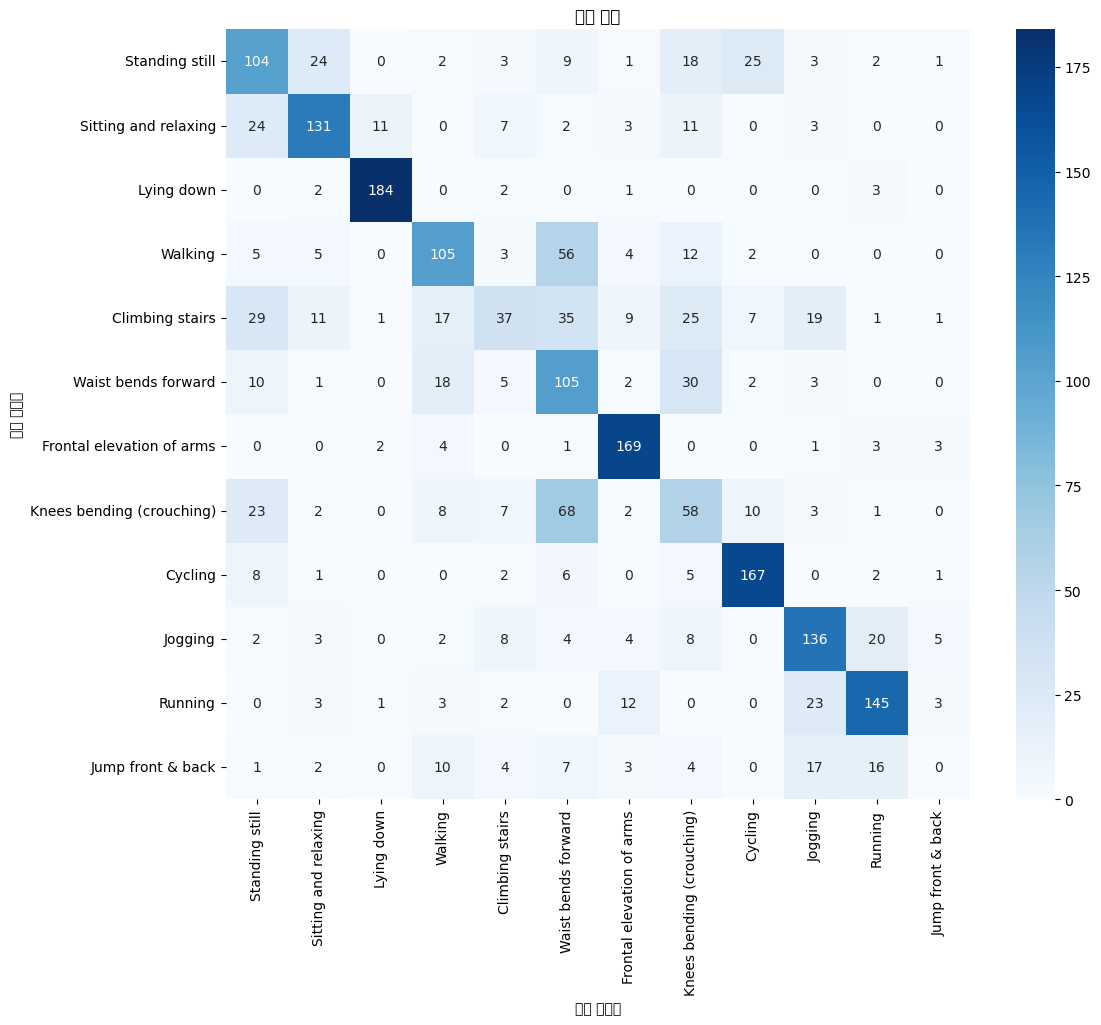

분류 보고서:
                           precision    recall  f1-score   support

           Standing still       0.50      0.54      0.52       192
     Sitting and relaxing       0.71      0.68      0.69       192
               Lying down       0.92      0.96      0.94       192
                  Walking       0.62      0.55      0.58       192
          Climbing stairs       0.46      0.19      0.27       192
      Waist bends forward       0.36      0.60      0.45       176
Frontal elevation of arms       0.80      0.92      0.86       183
Knees bending (crouching)       0.34      0.32      0.33       182
                  Cycling       0.78      0.87      0.82       192
                  Jogging       0.65      0.71      0.68       192
                  Running       0.75      0.76      0.75       192
        Jump front & back       0.00      0.00      0.00        64

                 accuracy                           0.63      2141
                macro avg       0.58      0.59      

In [20]:
# 저장된 모델 로드
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 클래스 이름 정의 (레이블 인덱스와 매칭)
class_names = [
    'Standing still',          # 레이블 0
    'Sitting and relaxing',    # 레이블 1
    'Lying down',              # 레이블 2
    'Walking',                 # 레이블 3
    'Climbing stairs',         # 레이블 4
    'Waist bends forward',     # 레이블 5
    'Frontal elevation of arms', # 레이블 6
    'Knees bending (crouching)', # 레이블 7
    'Cycling',                 # 레이블 8
    'Jogging',                 # 레이블 9
    'Running',                 # 레이블 10
    'Jump front & back'        # 레이블 11
]

# 혼동 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('실제 레이블')
plt.xlabel('예측 레이블')
plt.title('혼동 행렬')
plt.show()

# 분류 보고서 출력
print("분류 보고서:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 14. MergeData.csv 데이터에 대한 예측 및 레이블 추가
***
## 14.1 MergeData.csv 데이터 예측

In [21]:
# 저장된 스케일러 로드
scaler = joblib.load('scaler_total.pkl')

# 예측 결과를 저장할 리스트
predictions = []
indices = []

# MergeData.csv를 청크 단위로 로드하여 예측 수행
reader = pd.read_csv(merge_data_path,
                     chunksize=chunk_size,
                     names=column_names,
                     header=0)

for chunk in tqdm(reader, desc='MergeData 예측 중'):
    gyro_data = chunk[['X', 'Y', 'Z']].values
    
    if gyro_data.shape[0] < 128:
        continue

    windows = sliding_window(gyro_data,
                             window_size=128,
                             step_size=64)
    
    if windows.size == 0:
        continue

    # 특성 추출
    features = extract_features(windows)

    # 스케일링 적용
    features_scaled = scaler.transform(features)

    # 시퀀스 생성
    def create_sequences_unlabeled(features, seq_len):
        sequences = []
        
        for i in range(len(features) - seq_len + 1):
            seq = features[i:i+seq_len]
            sequences.append(seq)
            
        return np.array(sequences)

    X_seq = create_sequences_unlabeled(features_scaled, seq_len)

    if X_seq.size == 0:
        continue

    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

        # 각 시퀀스의 시작 인덱스를 저장
        window_starts = np.arange(0, len(features_scaled) - seq_len + 1)
        indices.extend(chunk.index.values[window_starts])

MergeData 예측 중: 2760it [4:12:34,  5.49s/it]


## 14.2 예측된 레이블 추가 및 저장

In [22]:
# 예측된 활동 이름으로 변환
predicted_activities = [class_names[pred] for pred in predictions]

# 결과를 DataFrame으로 저장
result_df = pd.DataFrame({
    'Index': indices,
    'Predicted Activity': predicted_activities
})

# 원본 MergeData에서 해당 인덱스의 데이터 추출
merge_data_full = pd.read_csv(merge_data_path,
                              names=column_names,
                              header=0)
predicted_data = merge_data_full.iloc[indices].copy()
predicted_data['Activity'] = predicted_activities

# 결과를 CSV 파일로 저장
predicted_data.to_csv('MergeData_Prediction.csv', index=False)
print("예측 결과를 'MergeData_Prediction.csv'에 저장했습니다.")

예측 결과를 'MergeData_Prediction.csv'에 저장했습니다.


## 14.3 예측 결과 시각화

C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu 

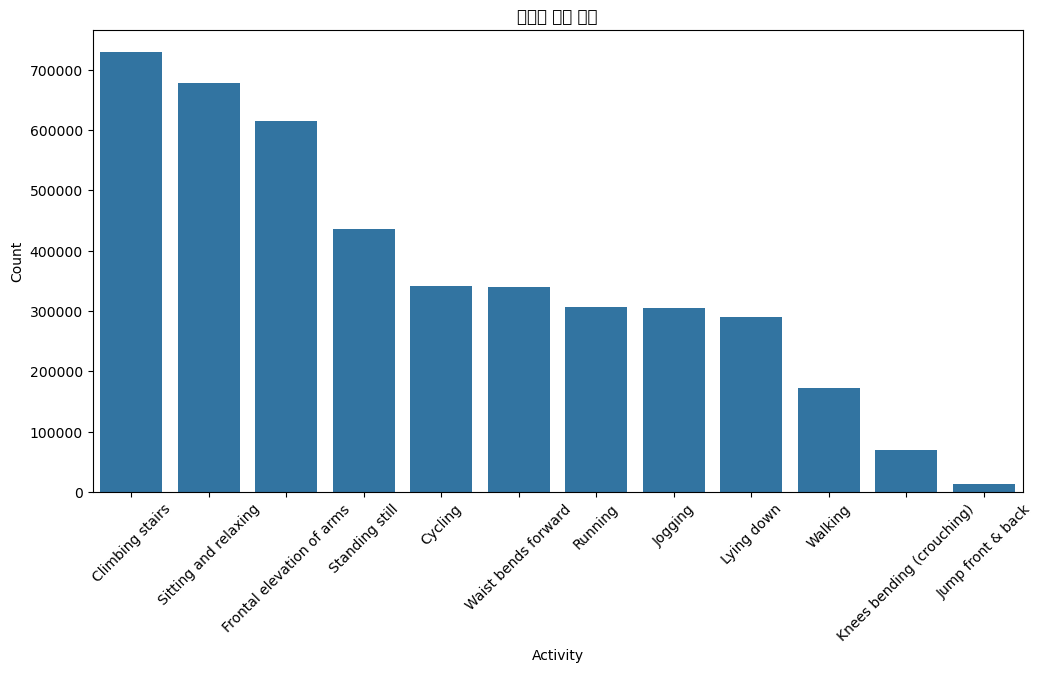

In [23]:
# 예측된 활동 레이블의 분포 시각화
activity_counts = pd.Series(predicted_activities).value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values)
plt.title('예측된 활동 분포')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()